## BloomTech Data Science

---

# Classification Metrics

- get and interpret the **confusion matrix** for classification models
- use classification metrics: **precision, recall**
- understand the relationships between precision, recall, **thresholds, and predicted probabilities**, to help **make decisions and allocate budgets**

In [1]:
%%capture
!pip install category_encoders==2.*

In [2]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Downloading the Tanzania Waterpump Dataset

Make sure  you only use the dataset that is available through the **DS** **Kaggle Competition**. DO NOT USE any other Tanzania waterpump datasets that you might find online.

There are two ways you can get the dataset. Make sure you have joined the competition first!:

1. You can download the dataset directly by accessing the challenge and the files through the Kaggle Competition URL on Canvas (make sure you have joined the competition!)

2. Use the Kaggle API using the code in the following cells. This article provides helpful information on how to fetch your Kaggle Dataset into Google Colab using the Kaggle API. 

> https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a

# Using Kaggle API to download datset

In [3]:
# mounting your google drive on colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#change your working directory, if you want to or have already saved your kaggle dataset on google drive.
%cd /content/gdrive/My Drive/Kaggle
# update it to your folder location on drive that contains the dataset and/or kaggle API token json file.

/content/gdrive/My Drive/Kaggle


In [5]:
# Download your Kaggle Dataset, if you haven't already done so. 
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# !kaggle competitions download -c bloomtech-water-pump-challenge 

In [6]:
# Unzip your Kaggle dataset, if you haven't already done so.
# !unzip \*.zip  && rm *.zip

In [7]:
# List all files in your Kaggle folder on your google drive.
!ls

2022-11-09_1838_submission.csv	sample_submission.csv  train_labels.csv
model_rf_gs_8033		test_features.csv
new_submission.csv		train_features.csv


# I. Wrangle Data

In [8]:
def wrangle(fm_path, tv_path=None):
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path, 
                              na_values=[0, -2.000000e-08],
                              parse_dates=['date_recorded']),
                  pd.read_csv(tv_path)).set_index('id')
    # Convert target to boolean
    df['needs_repair'] = df['status_group'].apply(lambda x: 0 if x=='functional' else 1)
    df.drop(columns='status_group', inplace=True)
     
  
  else:

    df = pd.read_csv(fm_path, 
                     na_values=[0, -2.000000e-08],
                     parse_dates=['date_recorded'],
                     index_col='id')
  

  # Drop constant columns
  df.drop(columns=['recorded_by'], inplace=True)

  # Create age feature
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns='date_recorded', inplace=True)

  # Drop HCCCs
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  # Drop duplicate columns # check for atleast a 100 values
  dupe_cols = [col for col in df.head(100).T.duplicated().index
               if df.head(100).T.duplicated()[col]]
  df.drop(columns=dupe_cols, inplace=True)             

  return df

df = wrangle(fm_path='train_features.csv',
             tv_path='train_labels.csv')

X_test = wrangle(fm_path='test_features.csv')

In [9]:
df.shape, X_test.shape

((47519, 31), (11880, 30))

## EDA


In [10]:
# Classify into pumps that need repair and pumps that do not need repairs.
# functional - class 0
# non functional, functional needs repair - class 1

In [11]:
# OPTION 1
# np.where(df['status_group']=='functional',0,1)

In [12]:
# OPTION 2
# (df['status_group'] != 'functional').astype(int)

In [13]:
# OPTION 3
# df['needs_repair'] = df['status_group'].apply(lambda x: 0 if x=='functional' else 1)

In [14]:
df.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,needs_repair,pump_age
id,,,,,,,,,,,,,,,,,,,,,
454.0,50.0,2092.0,35.426020,-4.227446,NaN,Internal,Manyara,21,1.0,160.0,...,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,0,15.0
510.0,NaN,NaN,35.510074,-5.724555,NaN,Internal,Dodoma,1,6.0,NaN,...,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump,0,NaN
14146.0,NaN,NaN,32.499866,-9.081222,NaN,Lake Rukwa,Mbeya,12,6.0,NaN,...,soft,good,enough,shallow well,shallow well,groundwater,other,other,1,NaN
47410.0,NaN,NaN,34.060484,-8.830208,NaN,Rufiji,Mbeya,12,7.0,NaN,...,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,1,NaN
1288.0,300.0,1023.0,37.032690,-6.040787,NaN,Wami / Ruvu,Morogoro,5,1.0,120.0,...,salty,salty,enough,shallow well,shallow well,groundwater,other,other,1,14.0


# II. Split Data

In [15]:
# Split TV / FM
target = 'needs_repair'
X = df.drop(columns=target)
y = df[target]

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanity check
assert len(X_train) + len(X_val) == len(X)

# Baseline

In [16]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425489938182296


# Build Model


In [17]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=25,n_jobs=-1,random_state=42)
)

model.fit(X_train, y_train);

# Interlude: Beware or Leakage

If you leave `'status_group'` in your feature matrix, you'll have **leakage**. 

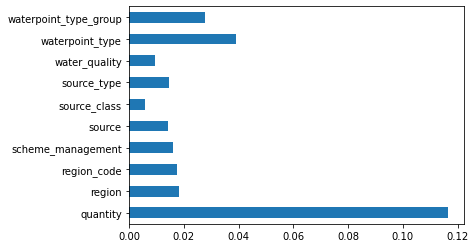

In [18]:
importances = model.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
pd.Series(importances, index=features).sort_index().tail(10).plot(kind='barh')

# Check Metrics

**Accuracy Score**

In [19]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.993870840457714
Validation Accuracy: 0.8067129629629629


In [20]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.993870840457714
Validation Accuracy: 0.8067129629629629


In [21]:
# total 10000 emails
# class 0 - 9900 - not spam
# class 1 - 100 - spam

9900/10000

0.99

**Confusion Matrix**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


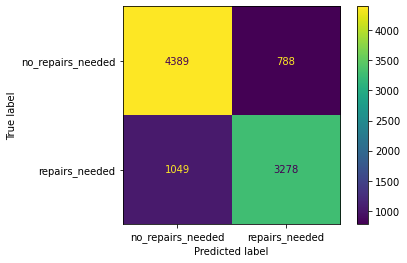

In [22]:
plot_confusion_matrix(
    model,
    X_val,
    y_val,
    values_format='.0f',
    display_labels=['no_repairs_needed', 'repairs_needed']
)

In [23]:
# confusion accuracy = (tn + tp)/ (sum(tn, tp, fn, fp)) (this is mainly helpful when you have a balanced dataset)

**Precision Score**

Of all the pumps that you predicted as needing repair, what proportion actually needed repair?

In [24]:
# precision = tp / (tp + fp)
# make sure what we're seeing as positive is actually positive

In [25]:
3278 / (3278 + 788)
# this is basically calculating the inverse percentage of money 'wasted'
  # every false positive is money spent to survey a pump that didn't need to be surveyed
    # we got ~80% precision, meaning 20% of inspections we lost finances

0.8061977373339891

**Recall Score** 

Of those pumps that actually needed repair, what proportion did you correctly predict as needing repair?

In [26]:
# recall tp/(tp+fn)
# see if we're missing out on positive observations

In [27]:
3278 / (3278+1049)
# this is basically calculating the inverse percentage of people left without water
  # every false negative is a pump that needed repairs that we didn't survey
    # we got ~75% recall, meaning 25% of pumps that needed repair, aren't going to get it. 

0.7575687543332563

**Classification Report**

In [28]:
print(classification_report(y_val,
                      model.predict(X_val),
                      target_names=['no_repairs_needed', 'repairs_needed']))

                   precision    recall  f1-score   support

no_repairs_needed       0.81      0.85      0.83      5177
   repairs_needed       0.81      0.76      0.78      4327

         accuracy                           0.81      9504
        macro avg       0.81      0.80      0.80      9504
     weighted avg       0.81      0.81      0.81      9504



In [29]:
#  increasing precision often means decreasing recall and vice-versa
# Generally speaking, we sould put emphasis on False Negatives (meaning high recall is often more important that precision)

# hypo-YouTube predictions: Having a higher precision is helpful (more important to put videos in front of people that they'll click on)
  # the goal is to just get videos that grab enough interest to get the click, many fps is acceptable because we just need the one tp

# in this case study:
# recall focuses: on giving priority to people who need the water 
  # Because a false negative is a pump needing repair but not getting it, each false negative is group of people without water
# precision focuses: on cutting unnecessary costs
  # because each false positive is a pump inspected that didn't need repairs after all

In [30]:
# however in cases where it's very important we get the best of both, the f1-score is the go-to option.
  # uses 'harmonic mean'
# f1-Formula: F-score = 2* (precision*recall)/ (precision+recall)

# Case Study

Let's say that is costs the Tanzanian government $100 to inspect a water pump, and there is only funding for 2000 pump inspections. 

In [31]:
n_inspections = 2000

Scenario 1: Choose pumps randomly

In [33]:
y_val.value_counts(normalize=True)
# blind probability that a random pump needs repair

0    0.544718
1    0.455282
Name: needs_repair, dtype: float64

In [37]:
repair_prob = 0.455282

In [38]:

print('Inspections conducted:',n_inspections)
print('Pumps repaired:', n_inspections * repair_prob)
print('Funds wasted:', int(n_inspections - n_inspections * repair_prob)*100) 

Inspections conducted: 2000
Pumps repaired: 910.5640000000001
Funds wasted: 108900


Scenario 2: Using our model "out of the box"

In [39]:
data = {
    'y_val':y_val,
    'y_pred': model.predict(X_val)
}

results =pd.DataFrame(data)

In [40]:
mask = (results['y_pred'] == 1)
sample = results[mask].sample(n_inspections)

In [41]:
print('Inspections conducted:', n_inspections)
print('Pumps repaired:',  sample['y_val'].sum())
print('Funds wasted:', int(n_inspections-sample['y_val'].sum())*100) 

Inspections conducted: 2000
Pumps repaired: 1608
Funds wasted: 39200


Scenario 3: We empasize **precision** in our model, and only select pumps that our model is very certain (`>0.85`) need repair.

In [ ]:
# in this case study we are focusing on precision because we have very limited funds, so we want to make sure as few money is wasted as possible
# according to our model we predicted that 3.2k need repairs, so if we can only do 2k repairs, we wanna be certain that we make the correct 2k repairs.

In [43]:
data = {
    'y_val':y_val,
    'y_pred_proba': model.predict_proba(X_val)[:,-1]
}

results =pd.DataFrame(data)

In [44]:
threshold = 0.85

In [45]:
mask = (results['y_pred_proba'] > threshold)
sample = results[mask].sample(n_inspections)

In [47]:
print('Inspections conducted:', n_inspections)
print('Pumps repaired:', sample['y_val'].sum())
print('Funds wasted:', int(n_inspections-sample['y_val'].sum())*100)

Inspections conducted: 2000
Pumps repaired: 1905
Funds wasted: 9500
